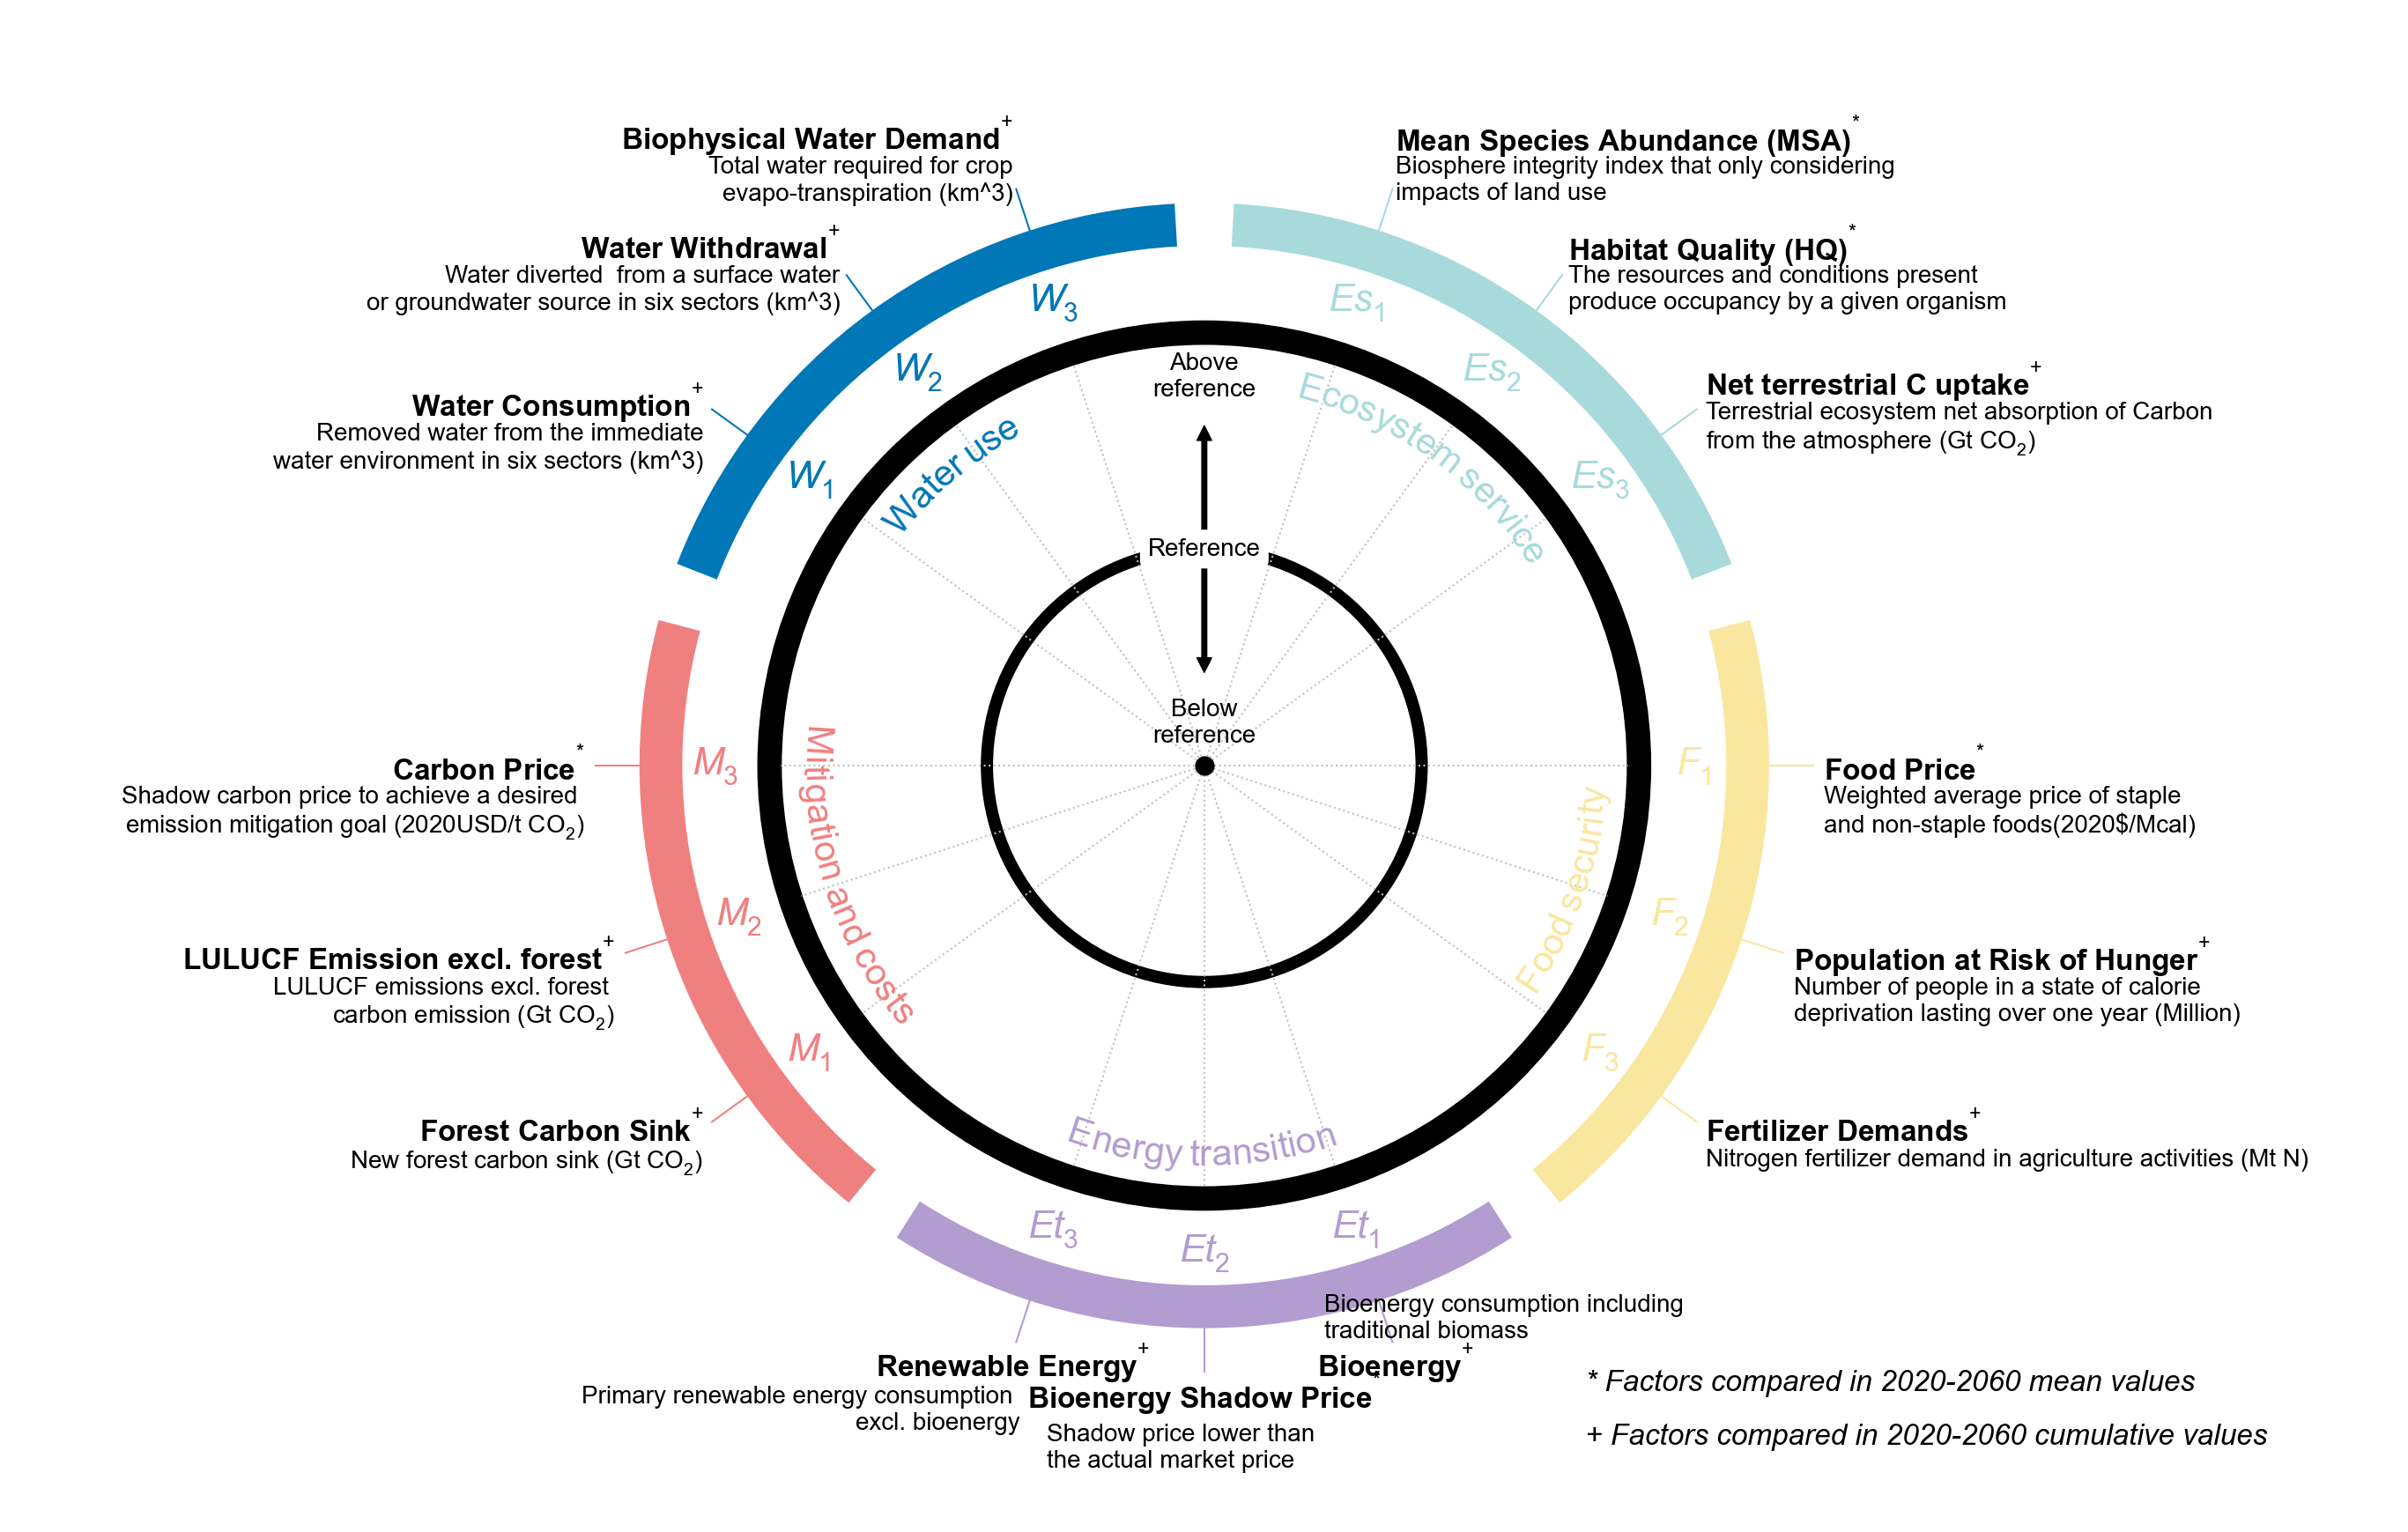

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pth
from matplotlib import text as mtext
import math


plt.rcParams['font.family']       = 'Arial'
plt.rcParams['font.sans-serif']   = ['Arial']
plt.rcParams['mathtext.fontset']  = 'custom'
plt.rcParams['mathtext.rm']       = 'Arial'

def point(angle, value):
    unit_x = 0.5 * np.cos((90 - angle) / 360 * np.pi * 2)
    unit_y = 0.5 * np.sin((90 - angle) / 360 * np.pi * 2)
    return (unit_x * value + 0.5, unit_y * value + 0.5)

class CurvedText(mtext.Text):
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0], y[0], ' ', **kwargs)
        axes.add_artist(self)
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()
        self.__Characters = []
        for c in text:
            if c == ' ':
                t = mtext.Text(0, 0, 'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0, 0, c, **kwargs)
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder + 1)
            self.__Characters.append((c, t))
            axes.add_artist(t)

    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c, t in self.__Characters:
            t.set_zorder(self.__zorder + 1)

    def draw(self, renderer, *args, **kwargs):
        self.update_positions(renderer)

    def update_positions(self, renderer):
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        figW, figH = self.axes.get_figure().get_size_inches()
        _, _, w, h = self.axes.get_position().bounds
        aspect = ((figW * w) / (figH * h)) * (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

        x_fig, y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
                (i, j) for i, j in zip(self.__x, self.__y)
            ]))
        )
        x_fig_dist = (x_fig[1:] - x_fig[:-1])
        y_fig_dist = (y_fig[1:] - y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist ** 2 + y_fig_dist ** 2)
        l_fig = np.insert(np.cumsum(r_fig_dist), 0, 0)
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]), (x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)

        rel_pos = 10
        for c, t in self.__Characters:
            t.set_rotation(0)
            t.set_va('center')
            bbox1 = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            if rel_pos + w / 2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue
            elif c != ' ':
                t.set_alpha(1.0)

            il = np.where(rel_pos + w / 2 >= l_fig)[0][-1]
            ir = np.where(rel_pos + w / 2 <= l_fig)[0][0]
            if ir == il:
                ir += 1
            used = l_fig[il] - rel_pos
            rel_pos = l_fig[il]
            fraction = (w / 2 - used) / r_fig_dist[il]

            x = self.__x[il] + fraction * (self.__x[ir] - self.__x[il])
            y = self.__y[il] + fraction * (self.__y[ir] - self.__y[il])
            t.set_va(self.get_va())
            bbox2 = t.get_window_extent(renderer=renderer)
            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0] - bbox1d[0])
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad) * aspect],
                [-math.sin(rad) / aspect, math.cos(rad)]
            ])
            drp = np.dot(dr, rot_mat)
            t.set_position(np.array([x, y]) + drp)
            t.set_rotation(degs[il])
            t.set_va('center')
            t.set_ha('center')
            rel_pos += w - used

names = [["Mean Species Abundance (MSA)$^{*}$", "Habitat Quality (HQ)$^{*}$", "Net terrestrial C uptake$^{+}$"],
         ["Food Price$^{*}$", "Population at Risk of Hunger$^{+}$",  "Fertilizer Demands$^{+}$"],
         ["Bioenergy$^{+}$", "Bioenergy Shadow Price$^{*}$","Renewable Energy$^{+}$",],
         ["Forest Carbon Sink$^{+}$", "LULUCF Emission excl. forest$^{+}$","Carbon Price$^{*}$"],
         ["Water Consumption$^{+}$", "Water Withdrawal$^{+}$", "Biophysical Water Demand$^{+}$"]]

expl = [[r"Biosphere integrity index that only considering"+"\n"+"impacts of land use",
         r"The resources and conditions present"+"\n"+"produce occupancy by a given organism",
         r"Terrestrial ecosystem net absorption of Carbon"+"\n"+"from the atmosphere (Gt CO$_2$)"],
        ["Weighted average price of staple" + "\n" + "and non-staple foods(2020$/Mcal)",
         r"Number of people in a state of calorie" + "\n" + "deprivation lasting over one year (Million)",
         r"Nitrogen fertilizer demand in agriculture activities (Mt N)"  ],
        [r"Bioenergy consumption incl." + "\n" + "traditional biomass  (EJ)",
         "Bioenergy shadow price (2020$/GJ)",
         r"Primary clean energy consumption excl. bioenergy (EJ)"],
        [r"New forest carbon sink (Gt CO$_2$)",
         r"LULUCF emissions excl. forest "+"\n"+r"carbon emission (Gt CO$_2$)",
         r"Shadow carbon price to achieve a desired "+"\n"+r"emission mitigation goal (2020USD/t CO$_2$)"],
        ["Removed water from the immediate" + "\n" + "water environment in six sectors (km^3)",
         "Water diverted  from a surface water" + "\n" + r"or groundwater source in six sectors (km^3)",
         "Total water required for crop" + "\n" + "evapo-transpiration (km^3)"]]

names2 = [[r"$Es_1$", r"$Es_2$", r"$Es_3$"],
          [r"$F_1$", r"$F_2$", r"$F_3$", ],
          [r"$Et_1$", r"$Et_2$", r"$Et_3$"],
          [r"$M_1$", r"$M_2$", r"$M_3$"],
          [r"$W_1$", r"$W_2$", r"$W_3$"]]

vars = names
Cats = ["Ecosystem service", "Food security", "Energy transition", "Mitigation and costs", "Water use"]

circle_border = plt.Circle((0.5, 0.5), 0.4, facecolor="white", edgecolor='k', lw=20)
circle_average = plt.Circle((0.5, 0.5), 0.2, facecolor="white", edgecolor='k', lw=10)
dr = 3
cols = ["#a8dadc", "#f9e79f", "#b39cd0", "#f08080", '#0077b6']
incr = 360 / len(vars)
da = (90 - 360 / len(vars))

arc_outer_1 = pth.Arc((0.5, 0.5), 1, 1, theta1=da + 0 + dr, theta2=da + incr - dr, color=cols[0], lw=35)
arc_outer_5 = pth.Arc((0.5, 0.5), 1, 1, theta1=da + incr * 4 + dr, theta2=da + incr * 5 - dr, color=cols[1], lw=35)
arc_outer_4 = pth.Arc((0.5, 0.5), 1, 1, theta1=da + incr * 3 + dr, theta2=da + incr * 4 - dr, color=cols[2], lw=35)
arc_outer_3 = pth.Arc((0.5, 0.5), 1, 1, theta1=da + incr * 2 + dr, theta2=da + incr * 3 - dr, color=cols[3], lw=35)
arc_outer_2 = pth.Arc((0.5, 0.5), 1, 1, theta1=da + incr + dr, theta2=da + incr * 2 - dr, color=cols[4], lw=35)

fig, ax = plt.subplots(1, 1, figsize=(28, 17.5))
ax.add_patch(circle_border)
ax.add_patch(circle_average)
ax.add_patch(arc_outer_1)
ax.add_patch(arc_outer_2)
ax.add_patch(arc_outer_3)
ax.add_patch(arc_outer_4)
ax.add_patch(arc_outer_5)
ax.plot([0.5], [0.5], 'ko', ms=15, zorder=1e99)

time = 2050
for vl_i, vl in enumerate(vars):
    for var_i, var in enumerate(vl):
        angle = (360 / len(vars)) * vl_i + ((360 / len(vars)) / (len(vl) + 1)) * (var_i + 1)
        p0 = point(angle, 0.39 * 2)
        ax.plot([0.5, p0[0]], [0.5, p0[1]], ':', c='silver', zorder=1)
        p0 = point(angle, 0.4 * 2 + 0.1)
        ax.text(p0[0], p0[1], names2[vl_i][var_i], fontsize=31, c=cols[vl_i], ha='center', va='center')
        p0 = point(angle, 0.4 * 2 + 0.2)
        p1 = point(angle, 0.4 * 2 + 0.32)
        p2 = point(angle, 0.4 * 2 + 0.34)
        if angle <= 160:
            a = 'left'
            dy = 0
            if vl_i == 0:
                dy = [0.10, 0.08, 0.08, 0.06, 0.06][var_i] - 0.06
        elif angle <= 200:
            a = 'center'
            dy = -0.01
        else:
            a = 'right'
            dy = 0
        if vl_i == 4:
            dy = [0.10, 0.08, 0.06][::-1][var_i] - 0.06
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c=cols[vl_i])
        ax.text(p2[0], p2[1] + dy, names[vl_i][var_i].replace('\n', ' '), fontsize=24, ha=a, va='center', weight='bold')
        if vl_i != 2:
            ax.text(p2[0], p2[1] - 0.018 + dy, expl[vl_i][var_i], fontsize=20, ha=a, va='top')

ax.text(0.5, 0.54, 'Below\nreference', fontsize=20, ha='center', va='center', zorder=1e999)
ax.text(0.5, 0.7, 'Reference', fontsize=20, ha='center', va='center', zorder=1e999, bbox=dict(boxstyle="round", ec='white', fc='white'))
ax.text(0.5, 0.86, 'Above\nreference', fontsize=20, ha='center', va='center', zorder=1e999)

dr = 0.4
r0 = 0
for c_i, c in enumerate(Cats):
    ph = [0.03, 0.2, 1.78, 1.36, 0.4][c_i] * np.pi
    if c_i == 0 or c_i == 4:
        text = CurvedText(
            x=0.36 * np.cos(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)[::-1]) + 0.5,
            y=0.36 * np.sin(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)[::-1]) + 0.5,
            text=c,
            color=cols[c_i],
            fontsize=30,
            ha='center',
            va='center',
            axes=ax,
        )
    if c_i == 1 or c_i == 2 or c_i == 3:
        text = CurvedText(
            x=0.36 * np.cos(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)) + 0.5,
            y=0.36 * np.sin(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)) + 0.5,
            text=c,
            color=cols[c_i],
            fontsize=30,
            ha='center',
            va='center',
            axes=ax,
        )

ax.annotate("", xy=(0.5, 0.82), xytext=(0.5, 0.7), arrowprops=dict(shrink=0.05, facecolor='k'))
ax.annotate("", xy=(0.5, 0.58), xytext=(0.5, 0.7), arrowprops=dict(shrink=0.05, facecolor='k'))

ax.text(0.61, -0.01 ,r"Bioenergy consumption including" + "\n" + "traditional biomass", fontsize=20, ha='left', va='center')
ax.text(0.355, -0.13 ,r"Shadow price lower than" + "\n" + "the actual market price", fontsize=20, ha='left', va='center')
ax.text(0.33, -0.095 ,r"Primary renewable energy consumption " + "\n" + "excl. bioenergy", fontsize=20, ha='right', va='center')

ax.text(0.85, -0.07, '* Factors compared in 2020-2060 mean values', fontsize=24, ha='left', va='center', zorder=1e999, style='italic')
ax.text(0.85, -0.12, '+ Factors compared in 2020-2060 cumulative values', fontsize=24, ha='left', va='center', zorder=1e999, style='italic')
ax.set_xlim([-0.6, 1.6])
ax.set_ylim([-0.2, 1.2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("/Users/shirley/Desktop/plots_V1/fig3/Sustainability_footprint.png", dpi=600, bbox_inches="tight")
plt.show()


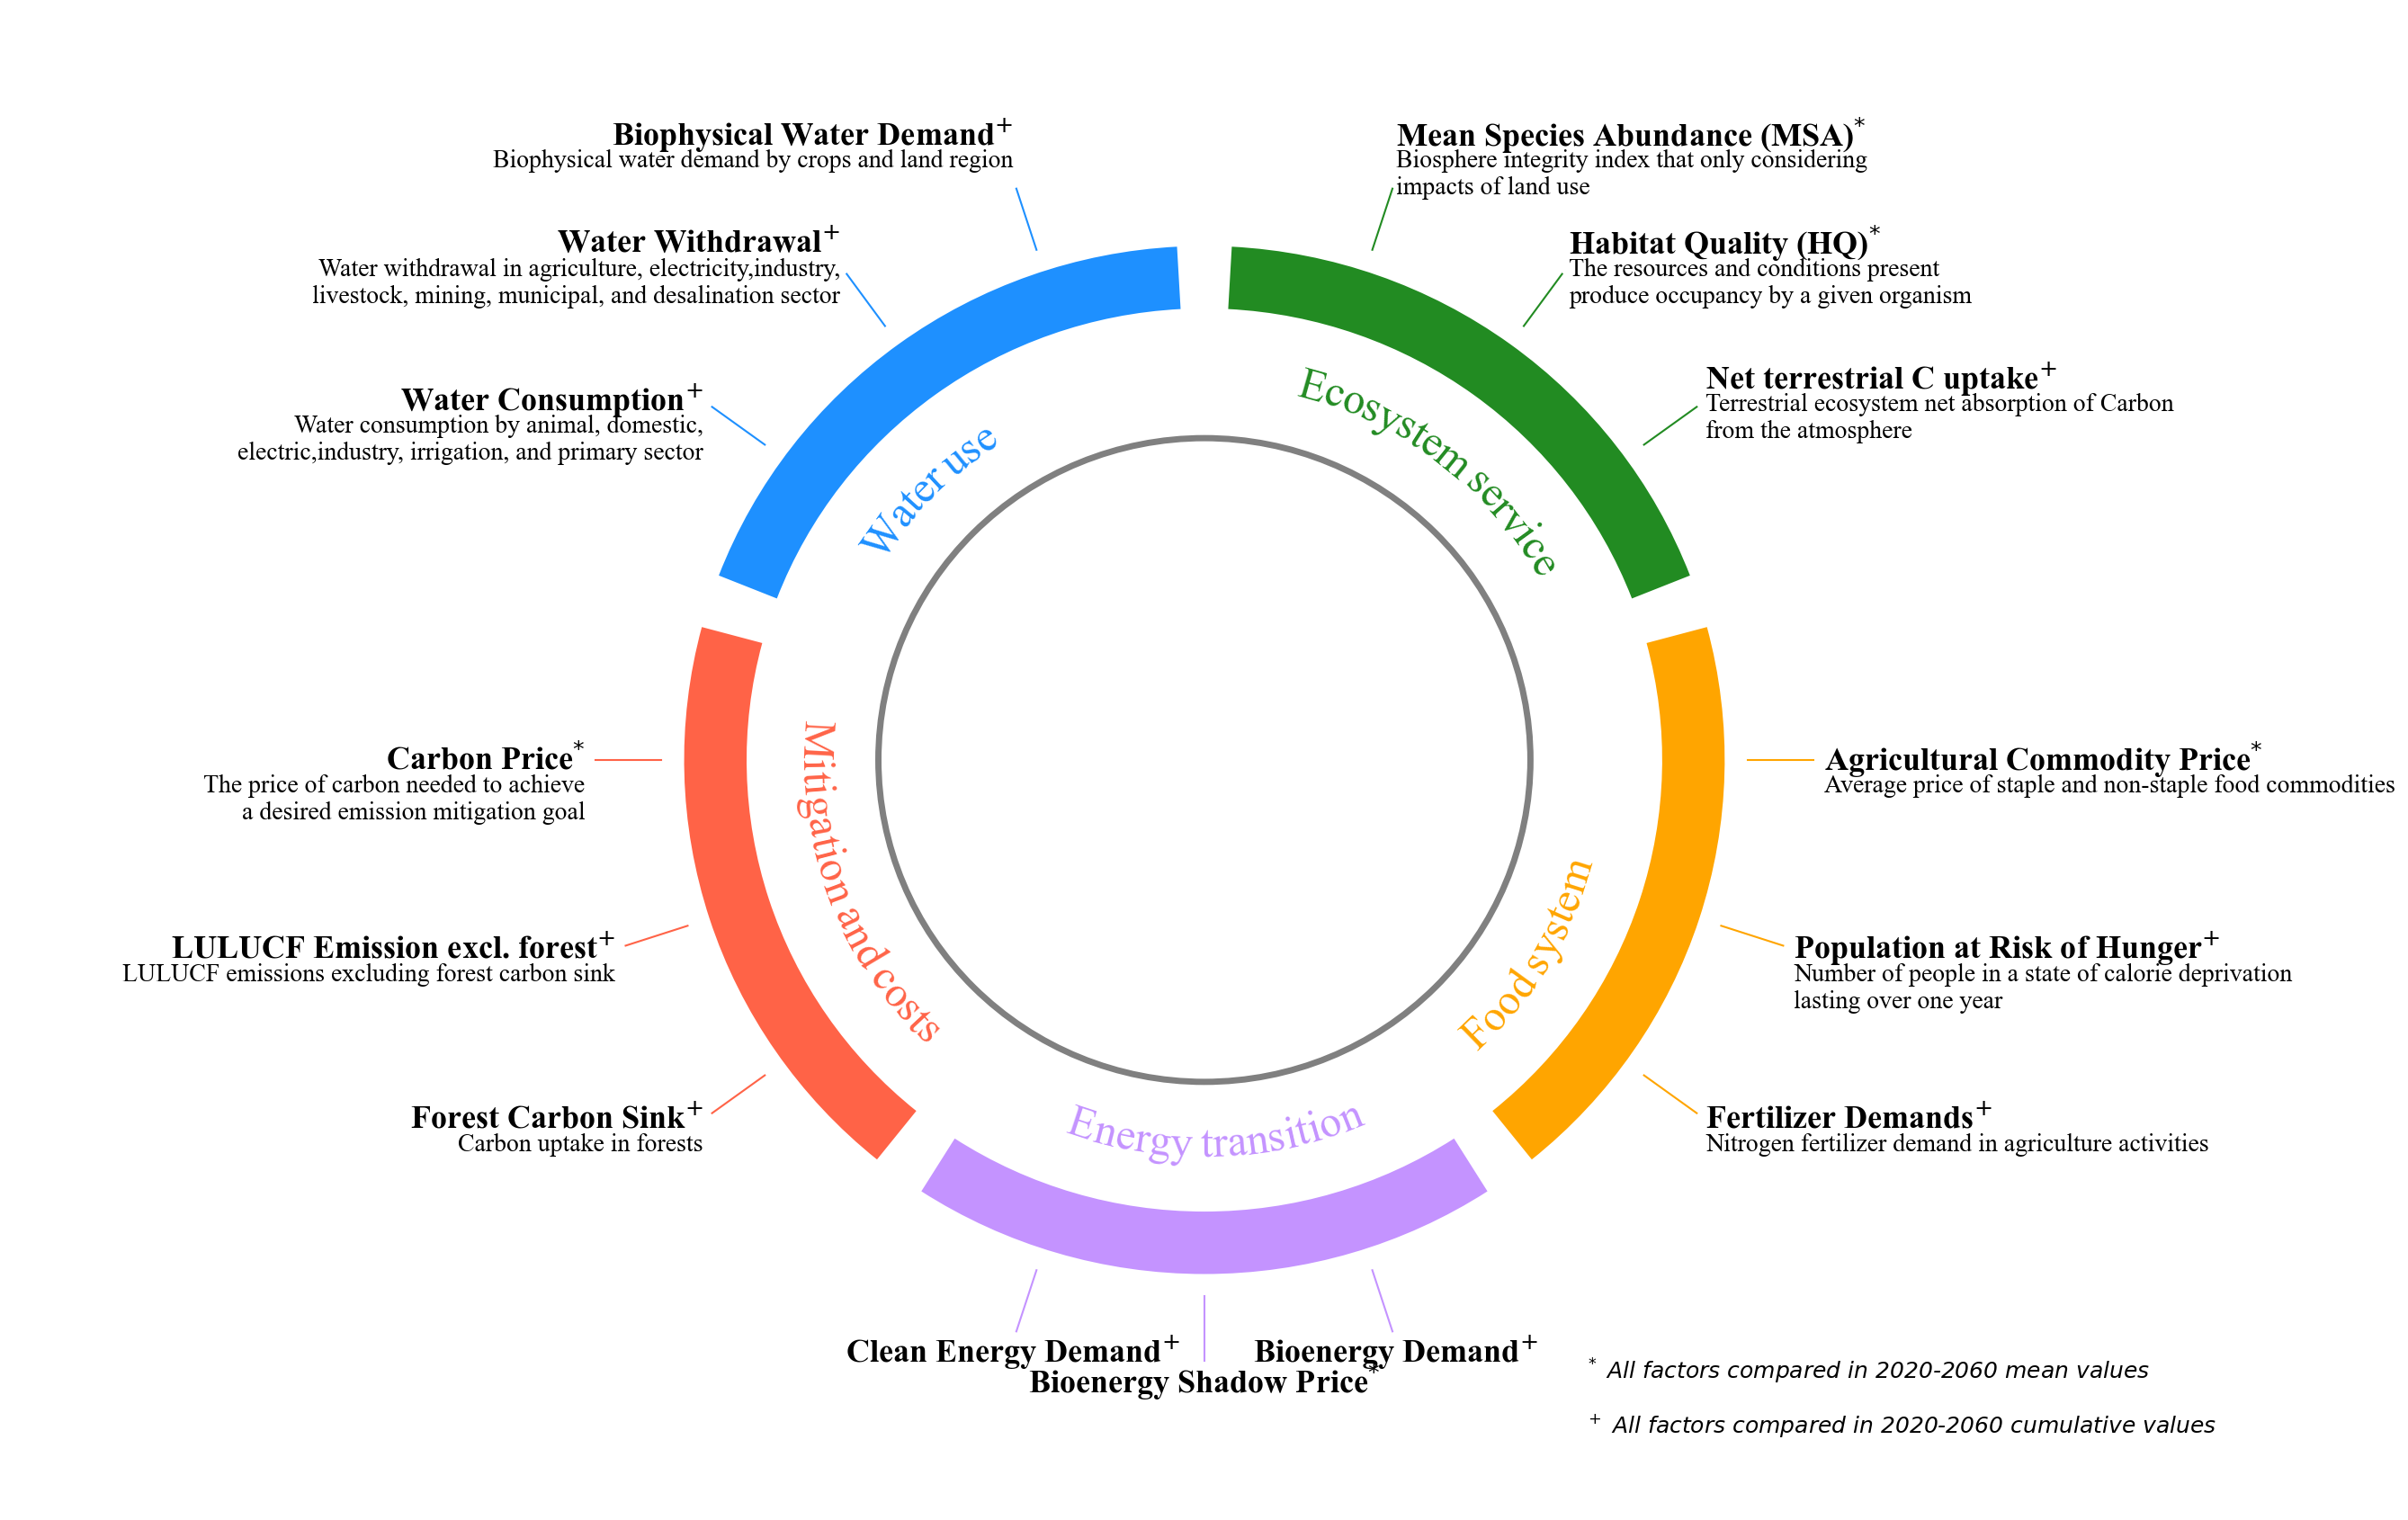

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pth
from matplotlib import text as mtext
import math

def point(angle, value):
    unit_x = 0.5 * np.cos((90 - angle) / 360 * np.pi * 2)
    unit_y = 0.5 * np.sin((90 - angle) / 360 * np.pi * 2)
    return (unit_x * value + 0.5, unit_y * value + 0.5)

class CurvedText(mtext.Text):
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0], y[0], ' ', **kwargs)
        axes.add_artist(self)
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()
        self.__Characters = []
        for c in text:
            if c == ' ':
                t = mtext.Text(0, 0, 'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0, 0, c, **kwargs)
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder + 1)
            self.__Characters.append((c, t))
            axes.add_artist(t)

    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c, t in self.__Characters:
            t.set_zorder(self.__zorder + 1)

    def draw(self, renderer, *args, **kwargs):
        self.update_positions(renderer)

    def update_positions(self, renderer):
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        figW, figH = self.axes.get_figure().get_size_inches()
        _, _, w, h = self.axes.get_position().bounds
        aspect = ((figW * w) / (figH * h)) * (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

        x_fig, y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
                (i, j) for i, j in zip(self.__x, self.__y)
            ]))
        )
        x_fig_dist = (x_fig[1:] - x_fig[:-1])
        y_fig_dist = (y_fig[1:] - y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist ** 2 + y_fig_dist ** 2)
        l_fig = np.insert(np.cumsum(r_fig_dist), 0, 0)
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]), (x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)

        rel_pos = 10
        for c, t in self.__Characters:
            t.set_rotation(0)
            t.set_va('center')
            bbox1 = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            if rel_pos + w / 2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue
            elif c != ' ':
                t.set_alpha(1.0)

            il = np.where(rel_pos + w / 2 >= l_fig)[0][-1]
            ir = np.where(rel_pos + w / 2 <= l_fig)[0][0]
            if ir == il:
                ir += 1
            used = l_fig[il] - rel_pos
            rel_pos = l_fig[il]
            fraction = (w / 2 - used) / r_fig_dist[il]

            x = self.__x[il] + fraction * (self.__x[ir] - self.__x[il])
            y = self.__y[il] + fraction * (self.__y[ir] - self.__y[il])
            t.set_va(self.get_va())
            bbox2 = t.get_window_extent(renderer=renderer)
            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0] - bbox1d[0])
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad) * aspect],
                [-math.sin(rad) / aspect, math.cos(rad)]
            ])
            drp = np.dot(dr, rot_mat)
            t.set_position(np.array([x, y]) + drp)
            t.set_rotation(degs[il])
            t.set_va('center')
            t.set_ha('center')
            rel_pos += w - used

names = [["Mean Species Abundance (MSA)$^{*}$", "Habitat Quality (HQ)$^{*}$", "Net terrestrial C uptake$^{+}$"],
         ["Agricultural Commodity Price$^{*}$", "Population at Risk of Hunger$^{+}$",  "Fertilizer Demands$^{+}$"],
         ["Bioenergy Demand$^{+}$", "Bioenergy Shadow Price$^{*}$","Clean Energy Demand$^{+}$",],
         ["Forest Carbon Sink$^{+}$", "LULUCF Emission excl. forest$^{+}$","Carbon Price$^{*}$"],
         ["Water Consumption$^{+}$", "Water Withdrawal$^{+}$", "Biophysical Water Demand$^{+}$"]]

expl = [[r"Biosphere integrity index that only considering"+"\n"+"impacts of land use",
         r"The resources and conditions present"+"\n"+"produce occupancy by a given organism",
         "Terrestrial ecosystem net absorption of Carbon"+"\n"+"from the atmosphere"],
        ["Average price of staple and non-staple food commodities",
         r"Number of people in a state of calorie deprivation" + "\n" + "lasting over one year",
         r"Nitrogen fertilizer demand in agriculture activities"  ],
        [r"Bioenergy consumption including " + "\n" + "residues, waste, and purpose-grown biocrops",
         "Bioenergy shadow price",
         r"Primary energy consumption excl. bioenergy"],
        [r"Carbon uptake in forests",
         r"LULUCF emissions excluding forest carbon sink",
         "The price of carbon needed to achieve"+"\n"+"a desired emission mitigation goal"],
        ["Water consumption by animal, domestic," + "\n" + r"electric, industry, irrigation, and primary sector",
         "Water withdrawal in agriculture, electricity,industry," + "\n" + r"livestock, mining, municipal, and desalination sector",
         "Biophysical water demand by crops and land region"]]

names2 = [[r"$Es_1$", r"$Es_2$", r"$Es_3$"],
          [r"$F_1$", r"$F_2$", r"$F_3$", ],
          [r"$Et_1$", r"$Et_2$", r"$Et_3$"],
          [r"$M_1$", r"$M_2$", r"$M_3$"],
          [r"$W_1$", r"$W_2$", r"$W_3$"]]

vars = names
Cats = ["Ecosystem service", "Food system", "Energy transition", "Mitigation and costs", "Water use"]

circle_border = plt.Circle((0.5, 0.5), 0.3, facecolor="white", edgecolor='grey', lw=5)
dr = 3
cols = ['forestgreen', 'orange', '#C493FF', 'tomato', 'dodgerblue']
incr = 360 / len(vars)
da = (90 - 360 / len(vars))
arc_outer_1 = pth.Arc((0.5, 0.5), 0.9, 0.9, theta1=da + 0 + dr, theta2=da + incr - dr, color=cols[0], lw=50)
arc_outer_5 = pth.Arc((0.5, 0.5), 0.9, 0.9, theta1=da + incr * 4 + dr, theta2=da + incr * 5 - dr, color=cols[1], lw=50)
arc_outer_4 = pth.Arc((0.5, 0.5), 0.9, 0.9, theta1=da + incr * 3 + dr, theta2=da + incr * 4 - dr, color=cols[2], lw=50)
arc_outer_3 = pth.Arc((0.5, 0.5), 0.9, 0.9, theta1=da + incr * 2 + dr, theta2=da + incr * 3 - dr, color=cols[3], lw=50)
arc_outer_2 = pth.Arc((0.5, 0.5), 0.9, 0.9, theta1=da + incr + dr, theta2=da + incr * 2 - dr, color=cols[4], lw=50)

fig, ax = plt.subplots(1, 1, figsize=(28, 17))
ax.add_patch(circle_border)
ax.add_patch(arc_outer_1)
ax.add_patch(arc_outer_2)
ax.add_patch(arc_outer_3)
ax.add_patch(arc_outer_4)
ax.add_patch(arc_outer_5)
#ax.plot([0.5], [0.5], 'ko', ms=15, zorder=1e99)

time = 2050
for vl_i, vl in enumerate(vars):
    for var_i, var in enumerate(vl):
        angle = (360 / len(vars)) * vl_i + ((360 / len(vars)) / (len(vl) + 1)) * (var_i + 1)
        p0 = point(angle, 0.39 * 2)
        #ax.plot([0.5, p0[0]], [0.5, p0[1]], ':', c='silver', zorder=1)
        p0 = point(angle, 0.4 * 2 + 0.1)
        #ax.text(p0[0], p0[1], names2[vl_i][var_i], fontsize=31, c=cols[vl_i], ha='center', va='center')
        p0 = point(angle, 0.4 * 2 + 0.2)
        p1 = point(angle, 0.4 * 2 + 0.32)
        p2 = point(angle, 0.4 * 2 + 0.34)
        if angle <= 160:
            a = 'left'
            dy = 0
            if vl_i == 0:
                dy = [0.10, 0.08, 0.08, 0.06, 0.06][var_i] - 0.06
        elif angle <= 200:
            a = 'center'
            dy = -0.01
        else:
            a = 'right'
            dy = 0
        if vl_i == 4:
            dy = [0.10, 0.08, 0.06][::-1][var_i] - 0.06
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c=cols[vl_i])
        ax.text(p2[0], p2[1] + dy, names[vl_i][var_i].replace('\n', ' '), fontsize=26, ha=a, va='center', weight='bold',fontname='Times New Roman')
        if vl_i != 2:
            ax.text(p2[0], p2[1] - 0.013 + dy, expl[vl_i][var_i], fontsize=20, ha=a, va='top',fontname='Times New Roman')

dr = 0.4
r0 = 0
for c_i, c in enumerate(Cats):
    ph = [0.03, 0.13, 1.78, 1.36, 0.43][c_i] * np.pi
    if c_i == 0 or c_i == 4:
        text = CurvedText(
            x=0.36 * np.cos(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)[::-1]) + 0.5,
            y=0.36 * np.sin(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)[::-1]) + 0.5,
            text=c,
            color=cols[c_i],
            fontsize=35,
            fontname='Times New Roman',
            ha='center',
            va='center',
            axes=ax,
        )
    if c_i == 1 or c_i == 2 or c_i == 3:
        text = CurvedText(
            x=0.36 * np.cos(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)) + 0.5,
            y=0.36 * np.sin(np.arange(r0 * np.pi - dr * np.pi + ph, r0 * np.pi + dr * np.pi + ph, 0.001)) + 0.5,
            text=c,
            color=cols[c_i],
            fontname='Times New Roman',
            fontsize=35,
            ha='center',
            va='center',
            axes=ax,
        )

#ax.text(0.85, -0.07, '$^*$ All factors (excluding carbon and energy intensity)\ncompared in 2020-2060 cumulative values', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')

ax.set_xlim([-0.6, 1.6])
ax.set_ylim([-0.2, 1.2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.text(0.85, -0.07, '$^*$ All factors compared in 2020-2060 mean values', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')
ax.text(0.85, -0.12, '$^+$ All factors compared in 2020-2060 cumulative values', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')

plt.tight_layout()
#plt.savefig("plots/Figure_1_modified.jpg", dpi=600, bbox_inches="tight")
plt.show()
